In [266]:
import torch
print('torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

torch 1.9.1+cu102 _CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


# Vision Meets Drones
**Challange 1 : Object Detection in Images**

Datasets available [Here](http://aiskyeye.com/)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/VisDrone2019-DET-train.zip

In [269]:
import glob
image_list = glob.glob('/content/VisDrone2019-DET-train/images/*.jpg') 
len(image_list)

6471

In [270]:
annot_list = glob.glob('/content/VisDrone2019-DET-train/annotations/*.txt') 
len(annot_list)

6471

## Convert VisDrone format to the YOLO one

## VisDrone Format
The format of each line is as follows: bbox_left, bbox_top, bbox_width, bbox_height, score, object_category, truncation, occlusion

The object category indicates the type of annotated object:

ignored regions (0), pedestrian (1), people (2), bicycle (3), car (4), van (5), truck (6), tricycle (7), awning-tricycle (8), bus (9),  motor (10), others (11).

## YOLO Format
*   One row per object
*   Each row is class x_center y_center width height format.
*   List itemBox coordinates must be in normalized xywh format (from 0 - 1). If your boxes are in pixels, divide x_center and width by image width, and y_center and height by image height.
*   Class numbers are zero-indexed (start from 0).

In [271]:
from PIL import Image

for file in annot_list:
        new_data=[]
        image_id=annot_list[0].split('/')[-1].split('.')[0]
        image_path='/content/VisDrone2019-DET-train/images/'+image_id+'.jpg'
        size = Image.open(image_path).size
        dw = 1. / size[0]
        dh = 1. / size[1]
        with open(file, 'r') as f1:
           data = f1.readlines()
        
        for dt in data:             
            x, y, w, h, ignored ,obj_class,_,_ =  map(float, dt.replace(',\n', '\n').split(','))
            if (ignored == 0  or obj_class == 11):  # VisDrone 'ignored regions' class 0  others 11
                      continue

            obj_class = int(obj_class) - 1
            cx = (x + w/2 ) * dw
            cy = (y + h/2 ) * dh
            
            w_new = w * dw
            h_new = h * dh

            new_data.append(f'{obj_class} {cx} {cy} {w_new} {h_new}\n')

        with open(file, 'w') as f2:
            f2.writelines( new_data )     

## Rename the annotation file

In [272]:
mv /content/VisDrone2019-DET-train/annotations /content/VisDrone2019-DET-train/labels

## Show a random sample: 

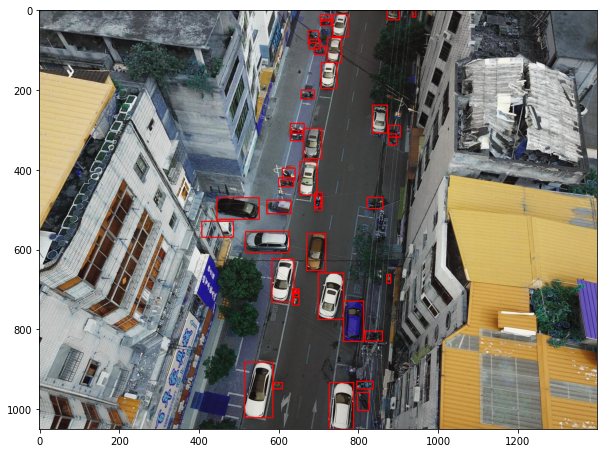

In [296]:
import matplotlib.pyplot as plt
import cv2
import random

i= random.randint(0,len(image_list))
image_id=image_list[i].split('/')[4].split('.')[0]
image_path='/content/VisDrone2019-DET-train/images/'+image_id+'.jpg'
anno_path='/content/VisDrone2019-DET-train/labels/'+image_id+'.txt'

img = cv2.imread(image_path)
dh, dw, _ = img.shape
        
fl = open(anno_path, 'r')
data = fl.readlines()
fl.close()

plt.figure(figsize = (10,10))   

for dt in data:
            
    obj_class, cx, cy, w, h =  map(float, dt.split(' '))

    x1 = round( (cx-(w*0.5))*dw  )
    y1 = round( (cy-(h*0.5))*dh  )

    x2 = round( (cx+(w*0.5))*dw  )
    y2 = round( (cy+(h*0.5))*dh )
    

    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0),2)
                   
plt.imshow(img)

# Running YOLOv5

In [69]:
!git clone https://github.com/ultralytics/yolov5  # clone repo

Cloning into 'yolov5'...
remote: Enumerating objects: 9152, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 9152 (delta 1), reused 3 (delta 0), pack-reused 9143
Receiving objects: 100% (9152/9152), 9.76 MiB | 11.09 MiB/s, done.
Resolving deltas: 100% (6346/6346), done.


In [ ]:
!pip install -U -r yolov5/requirements.txt  # install dependencies

In [1]:
cd /content/yolov5

/content/yolov5


In [2]:
!ls

CONTRIBUTING.md  export.py   __pycache__       train.py        yolov5s.pt
data		 hubconf.py  README.md	       tutorial.ipynb
detect.py	 LICENSE     requirements.txt  utils
Dockerfile	 models      runs	       val.py


/content/yolov5/data/VisDrone.yaml should be updated to match the dataset directories.

In [3]:
! python train.py --img 1024 --batch 16 --epochs 5 --data /content/yolov5/data/VisDrone.yaml --weights yolov5s.pt 


Plotting labels... 

autoanchor: Analyzing anchors... anchors/target = 3.77, Best Possible Recall (BPR) = 0.9804
Image sizes 1024 train, 1024 val
Using 2 dataloader workers
Logging results to runs/train/exp19
Starting training for 5 epochs...

     Epoch   gpu_mem       box       obj       cls    labels  img_size
       0/4     8.54G    0.1012    0.2225   0.04883        97      1024: 100% 313/313 [14:23<00:00,  2.76s/it]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 157/157 [06:32<00:00,  2.50s/it]
                 all       4994     247220      0.149     0.0543     0.0316     0.0128

     Epoch   gpu_mem       box       obj       cls    labels  img_size
       1/4     10.1G    0.0838    0.2466   0.03748       268      1024: 100% 313/313 [14:13<00:00,  2.73s/it]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 157/157 [05:50<00:00,  2.23s/it]
                 all       4994     247220       0.18

## Detection Results

In [5]:
!python detect.py --source /content/VisDrone2019-DET-train/images/9999972_00000_d_0000131.jpg

detect: weights=yolov5s.pt, source=/content/VisDrone2019-DET-train/images/9999972_00000_d_0000131.jpg, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False
YOLOv5 🚀 v5.0-455-g59aae85 torch 1.9.1+cu102 CUDA:0 (Tesla K80, 11441.1875MB)

Fusing layers... 
Model Summary: 224 layers, 7266973 parameters, 0 gradients
image 1/1 /content/VisDrone2019-DET-train/images/9999972_00000_d_0000131.jpg: 384x640 7 cars, 1 truck, Done. (0.019s)
Speed: 0.4ms pre-process, 18.8ms inference, 3.1ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp


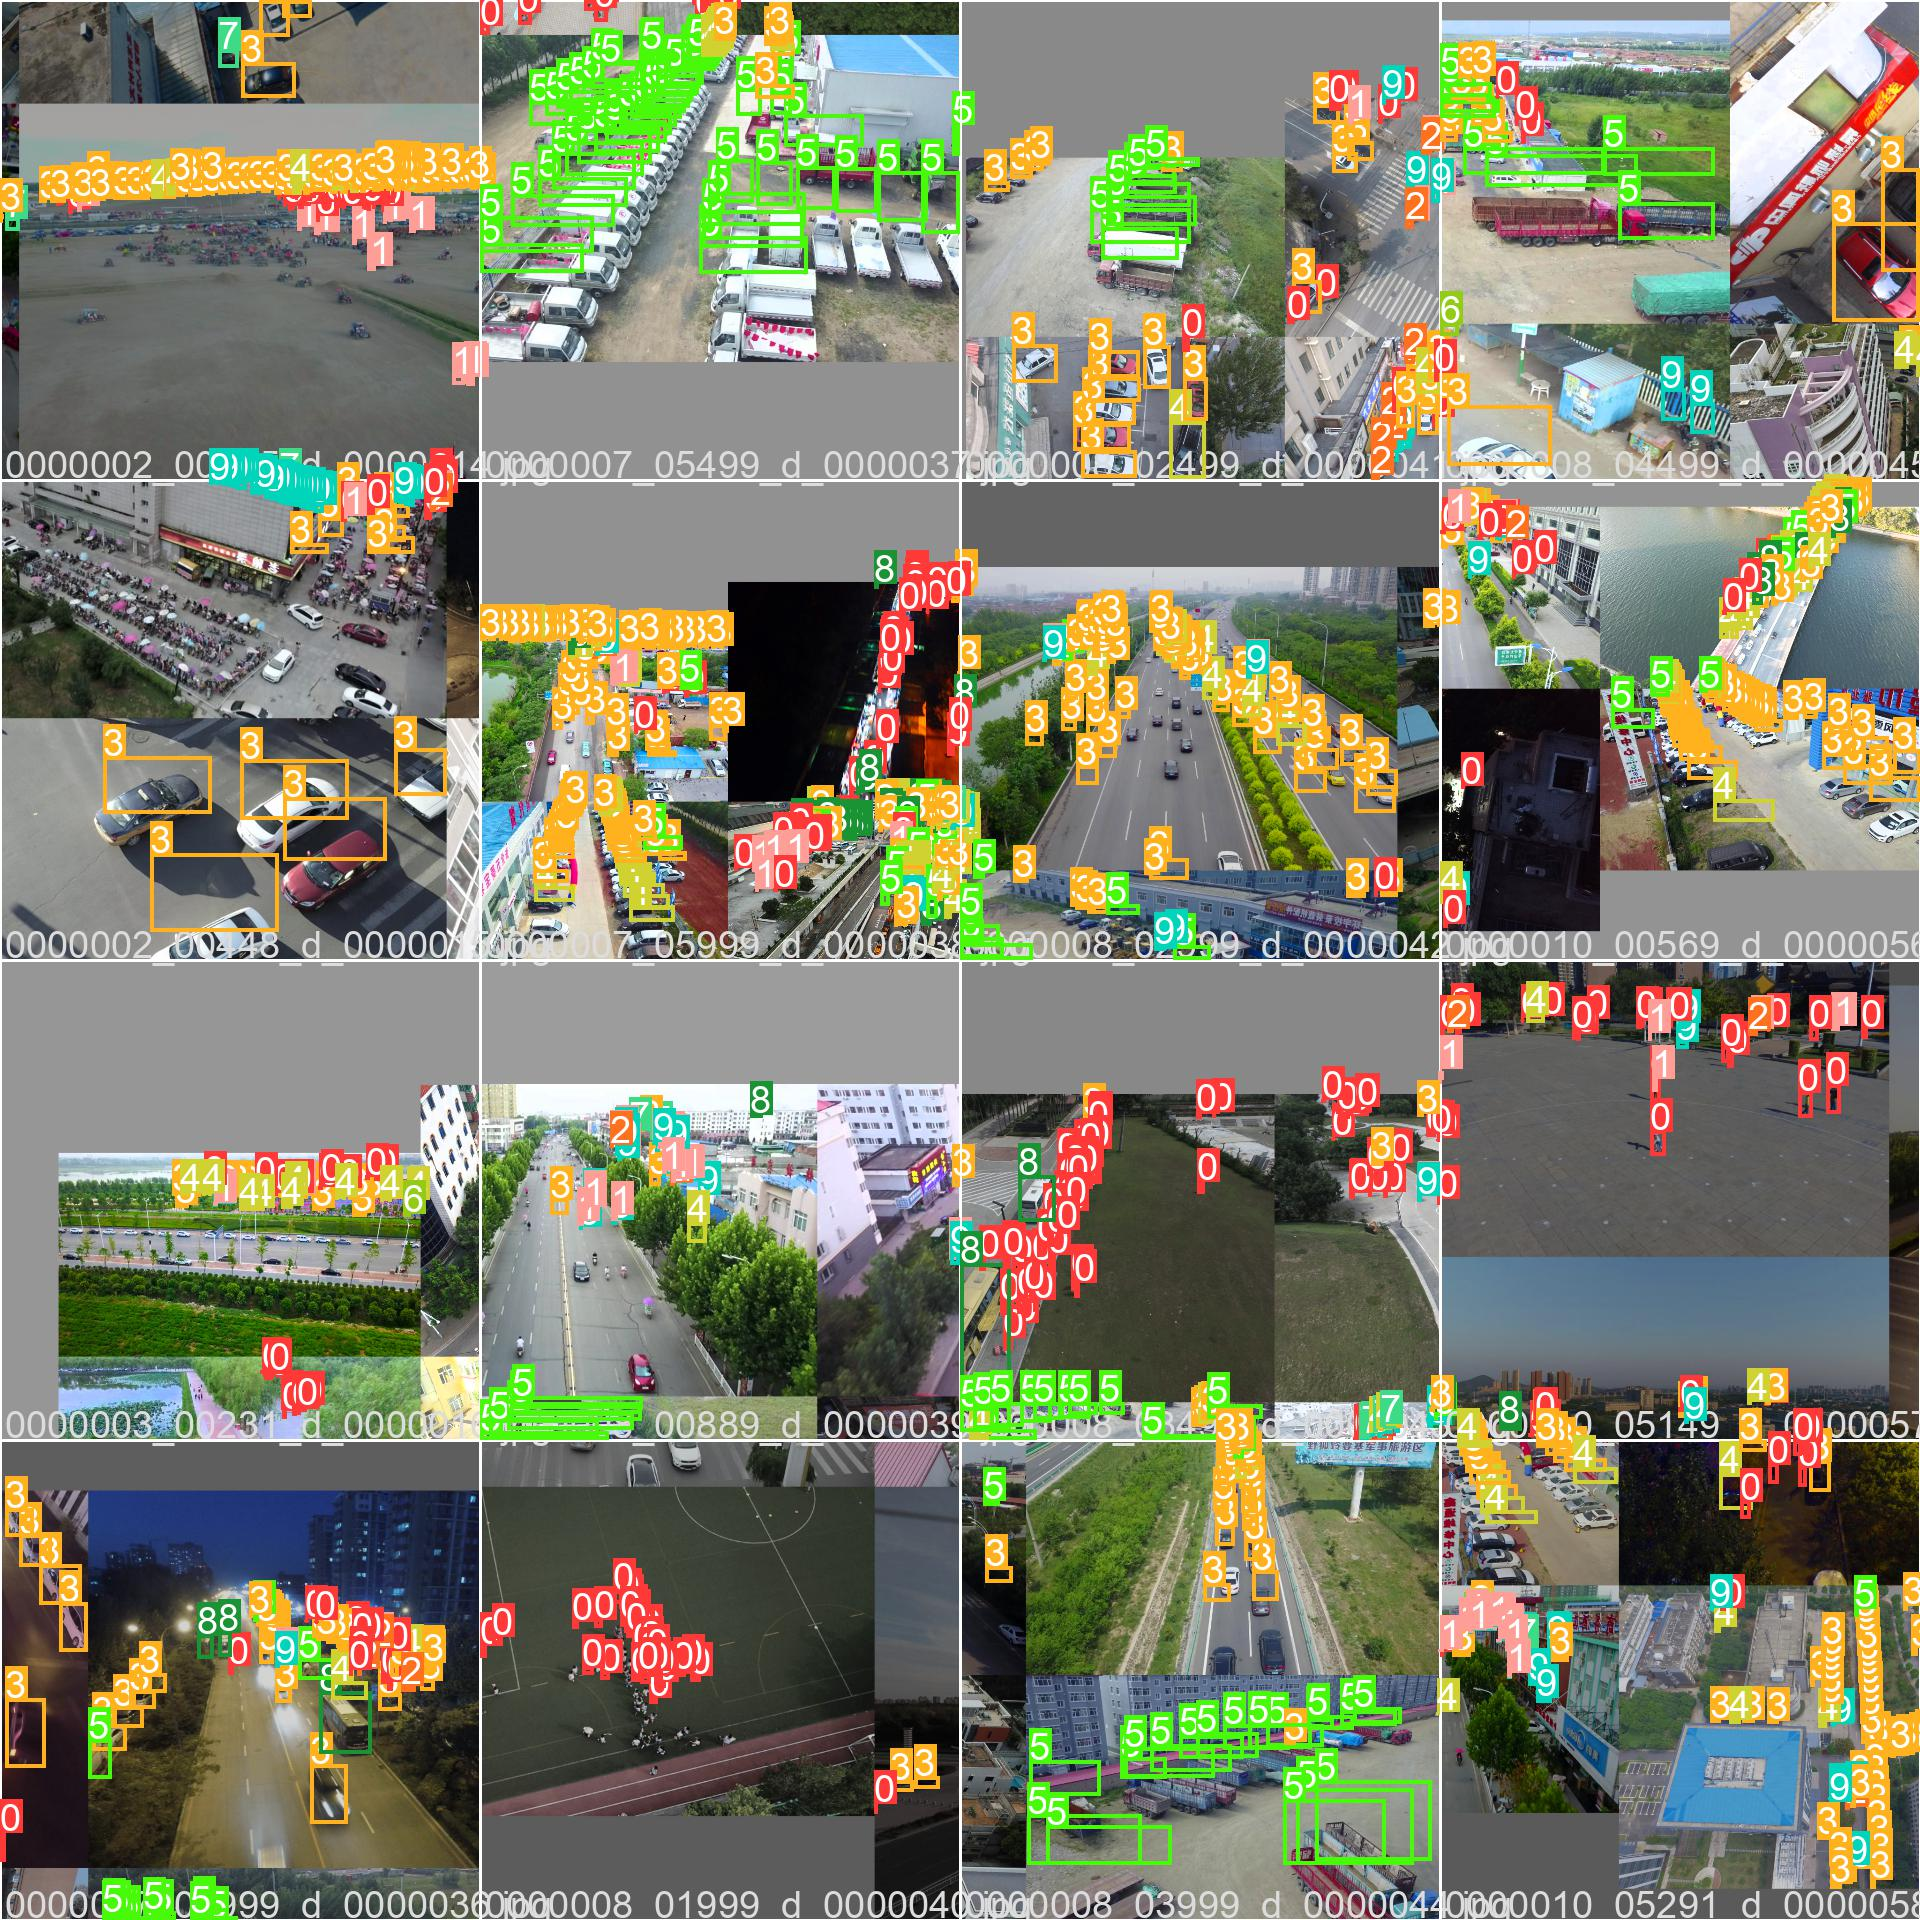

In [6]:
from IPython.display import Image
Image(filename='/content/yolov5/runs/train/exp19/train_batch0.jpg') 

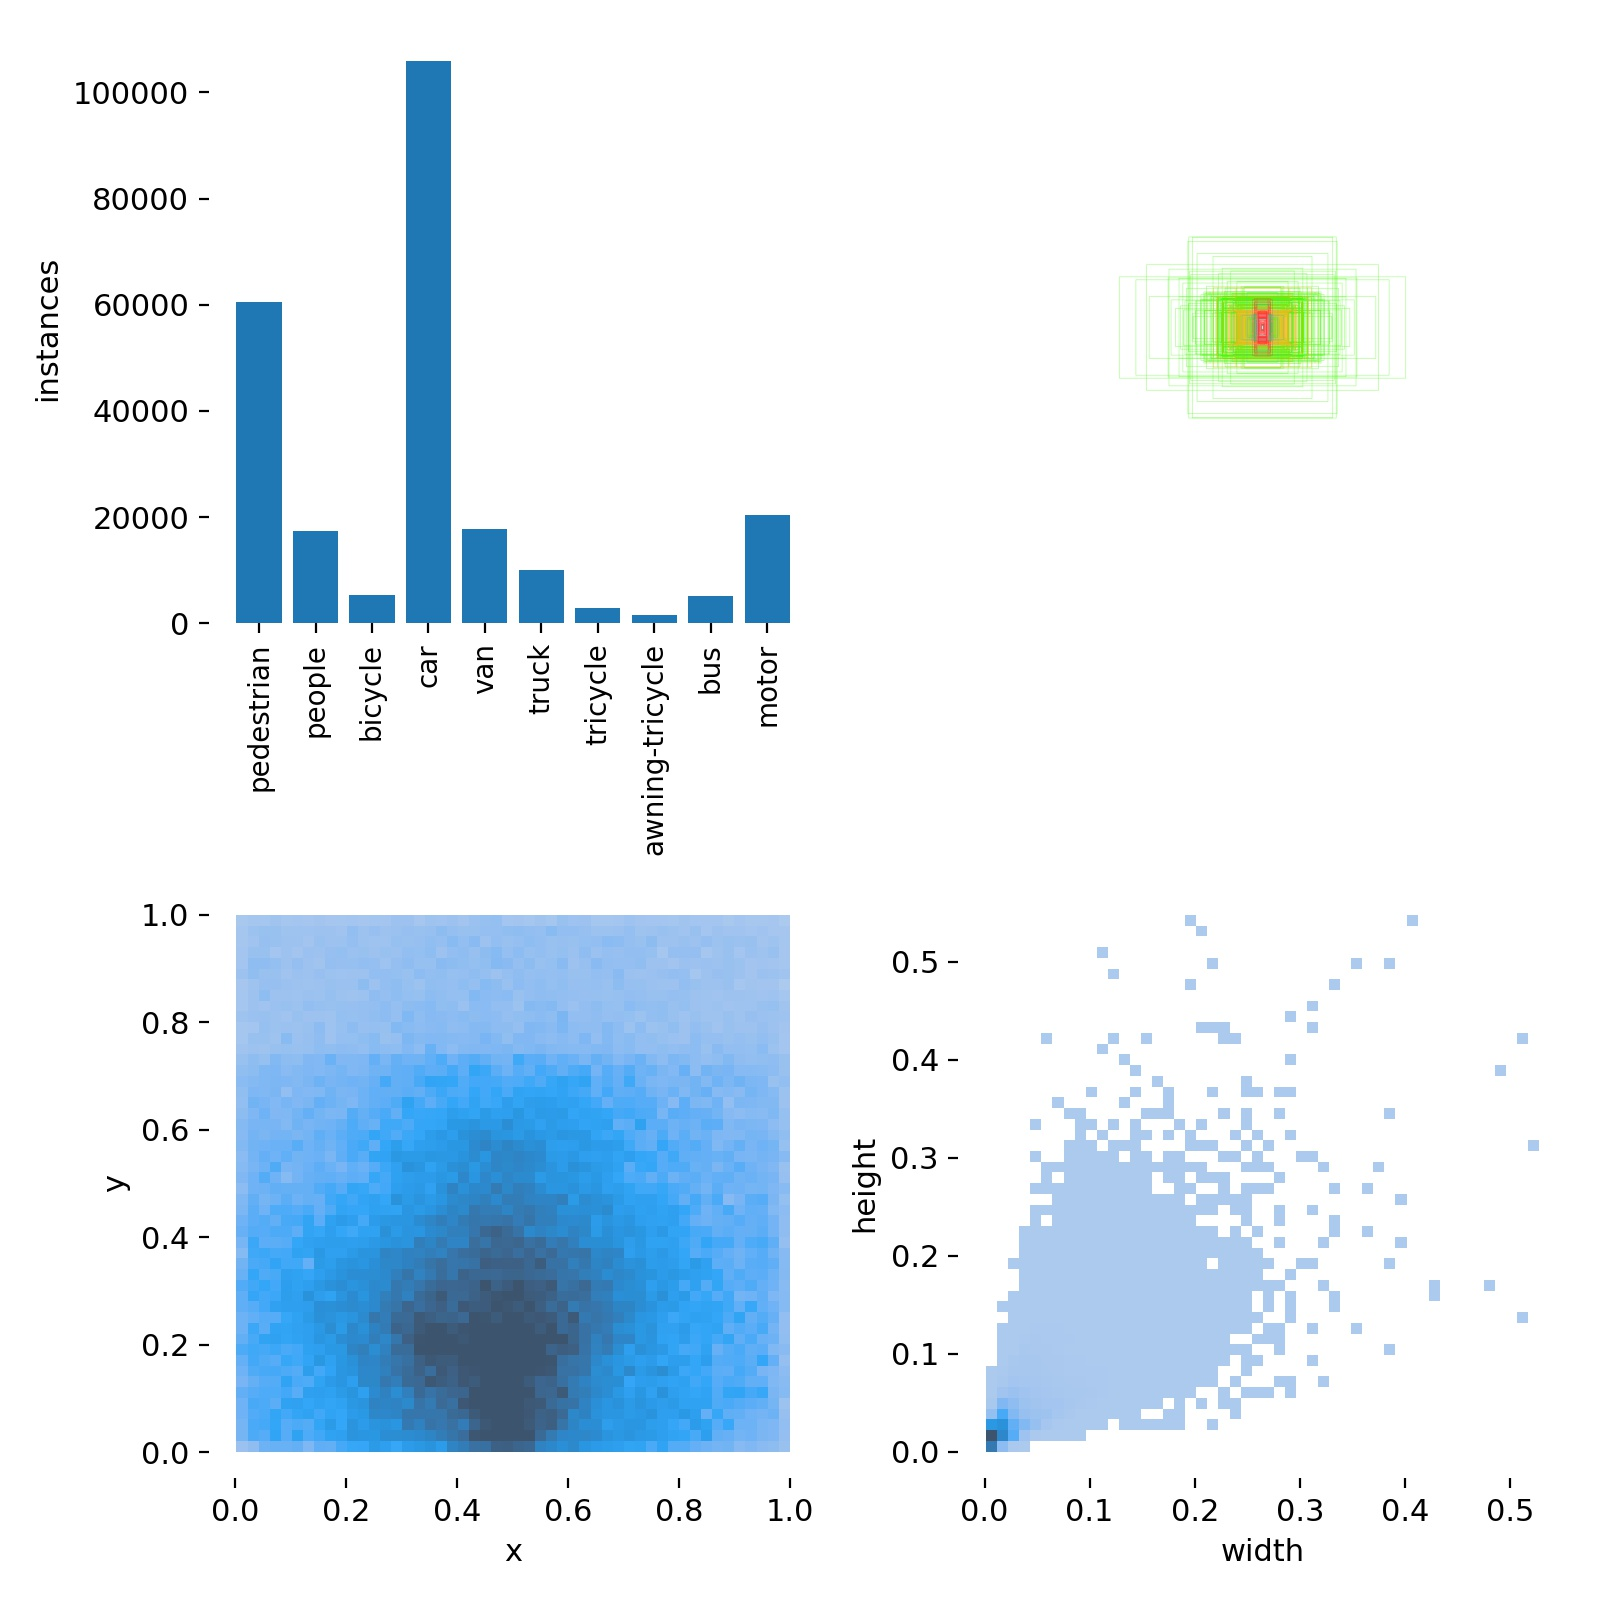

In [9]:
Image(filename='/content/yolov5/runs/train/exp19/labels.jpg') 